In [1]:
import sys
from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline

sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

# Machine Learning lab 6: wide and deep networks
## Jake Rowland and Paul Herz
2017-11-03

## 1. Introduction

In the prior labs requiring table data, we used the *IMDB Top 5000 Movie Dataset*. However, we repeatedly ran into issues with the classification task we had assigned ourselves and the artificial labels we applied to the dataset. There was nothing inherently wrong with the data after cleaning, but our approach was flawed. In the third lab using such data, we acknowledged our mistake but chose to continue using the same dataset and classification task for consistency's sake (you can read more in that report). However, we have finally decided to start anew with a different dataset and thus a different task. We could have kept the old dataset but chosen a new task, but we thought that would be somewhat misleading to change the rules so slightly with the same dataset we had already used.

We operate on the [Diamonds](https://www.kaggle.com/shivam2503/diamonds/data) dataset, which includes information on ~54,000 diamonds. Those who have shopped for diamonds may be familiar with the "four C's": color, clarity, cut, and carat weight. Diamonds are rated D-Z on color, D being perfectly colorless. Clarity consists of 11 grades, judged by an expert looking for internal inclusions and surface blemishes. Carat weight simply represents the weight (and therefore size) of the diamond. We were interested in cut—which has nothing to do with the diamond's overall shape (round, princess, pair)—but rather how perfectly the facets were made in the stone to enhance its optical properties and create the sparkling for which diamonds are well known [(Citation)](http://4cs.gia.edu/en-us/4cs-diamond-quality/). Unlike color and clarity, which rely on the nature of the raw diamond, cut is a factor of several geometric properties of the diamond once it has been cut (tautological though it may sound). 

![](cut.png)

A diamond's "table," when referring to a number, is the ratio of the width of its table (the flat top) to the total width of the diamond. "Depth" is the distance from the table to the "cutlet" (point) divided by the diamond's width [(Citation)](https://www.brilliance.com/diamonds/ideal-depth-table-round-cut-diamonds). According to the source, the acceptable range for table is 50-69%, while ideally it is 54-60%. Similarly for depth, 56.5-65% is OK while 59.5-62.9% is best.

### 1.1 Background

Not much information is provided by the dataset's publisher on Kaggle, `shivamagrawal`; there is not even a license under which it is published. The tagline reads "It's a great dataset for beginners learning to work with data analysis and visualization." Despite the lack of overall context for this dataset (in stark contrast with our prior datasets), we see opportunity for a useful task that can be performed on diamond data such as this example dataset—this dataset simply enables us to experiment and demonstrate said task.

### 1.2 Business Case

When a raw diamond is mined, its preexisting geometric, geological, and aesthetic characteristics are then known. Many of these mined diamonds become industrial diamonds: used as abrasive coatings, grinding agents, or polishing agents. However, mostly lab-created diamonds are used for this purpose as a matter of economics [(Citation)](https://minerals.usgs.gov/minerals/pubs/commodity/diamond/diamomyb03.pdf). The best mined diamonds, with the fewest imperfections and impurities, are candidates for jewelry. Cutting raw diamond into jewels is not only an art, but a science. As mentioned earlier, there are precise tolerances within which a diamond's reflectivity and luminance are optimized, and those parameters may differ between diamonds. A cutter must make an economic and a risk decision when deciding how "greedy" to be with a cut—cutting closer to the edges of the raw diamond wastes less, and results in a larger carat size, but almost invariably throws off the ideal proportions of table and depth, thus leading to poor cut. Cutting too small doesn't guarantee a good cut, but it wastes the financial worth of the diamond.

In some sense, many parameters of the diamond's geometry, chemistry, and aesthetic factors into the others, and they all factor into price. We were not necessarily interested in price, namely because this was a classification task we had to pursue, but also because the relationship between diamond parameters and price is well-known, and can probably be broken down to a basic formula. Additionally, were we to artificially divide the dataset into price groups, we would be walking into the same trap from our IMDB dataset reports. As such, we wanted to see how **cut** is affected by the other parameters of the diamond (less price, of course). The aforementioned process of economics and risk that influences how the diamond is cut is not so well-known, and represents and interesting area of investigation.

Furthermore, we believe that there is a clear and apparent business interest to jewelers and the diamond industry here—being able to predict how a cut may turn out before a single strike has been made on the stone. Clearly, the skill of the cutter (or the precision of the cutting machine) factor in greatly, but we would like to investigate if at least a preliminary prediction can be made. Such a prediction of cut outcome would enable these industries to make medium-term financial estimates more accurately by factoring in the incoming worth of new stones before they've been manually assessed. Taken to an extreme, it could even allow such industries to make purchasing decisions in their dealings with mines and/or laboratories, reducing expenses and increasing margins.

The diamond industry is not very large compared to some more mainstream industries, but it is still an economic juggernaut in the modern day, and we believe that performance demonstrated here could be adapted to other geological problem sets.

### 1.3 Serviceability

## 2. The dataset: preprocessing and review

### 2.1 Dataset preparation

### 2.2 Data quality

### 2.3 Modifying the dataset for classification compatibility

#### Final format after preprocessing

## 3. Evaluation, training, and testing

### 3.1 Evaluation criteria

### 3.2 Cross validation methodology

## 4. Modeling

### 4.1 Our wide and deep network implementation (Keras)

### 4.3 Evaluation and cross validation

### 4.4 Experimentation

#### Generalization performance and number of layers

#### Comparing W+D with a basic MLP (ROC AUC)

In [2]:
# https://www.kaggle.com/shivam2503/diamonds/data
diamonds = pd.read_csv('data/diamonds.csv')

# Features
data = deepcopy(diamonds[['carat', 'x', 'y', 'z', 'depth', 'table', 'price',
                          'clarity', 'color']])
# Labels
target = deepcopy(diamonds['cut']).astype('category')

# Force all numerical data to zero mean one std
for col in ['carat','x','y','z','depth','table','price']:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

# Define color and clarity as categorical types
for col in ['color', 'clarity']:
    data[col] = data[col].astype('category');

data.describe()

,carat,x,y,z,depth,table,price
count,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04
mean,2.149807e-16,2.508108e-16,-2.107654e-17,-2.023348e-16,-4.002434e-15,1.175017e-16,-1.095980e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.261446e+00,-5.109073e+00,-5.020884e+00,-5.014510e+00,-1.308748e+01,-6.470013e+00,-9.040868e-01
25%,-8.395154e-01,-9.103164e-01,-8.882717e-01,-8.909378e-01,-5.231005e-01,-6.521325e-01,-7.476738e-01
50%,-2.066190e-01,-2.777527e-02,-2.147379e-02,-1.237607e-02,3.531645e-02,-2.046032e-01,-3.839636e-01
75%,5.106635e-01,7.210475e-01,7.052356e-01,7.103118e-01,5.239313e-01,6.904554e-01,3.487834e-01
max,8.885992e+00,4.465161e+00,4.654922e+01,4.004720e+01,1.204128e+01,1.680151e+01,3.732404e+00


In [23]:
from functools import reduce
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Embedding, Flatten, Merge, concatenate
from keras.callbacks import Callback

class WideDeepNetwork():
    def __init__(
        self, epochs=5, batch_size=35, activation='relu', final_activation='sigmoid', optimizer='adagrad', 
        loss='mean_squared_error', metrics=['accuracy'], deep_input_size=5, 
        deep_layer_sizes=[50,10], numeric_features=None, categorical_features=None,
        cross_categories=None,
    ):
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.activation = activation
        self.final_activation = final_activation
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        
        self.deep_input_size = deep_input_size
        self.deep_layer_sizes = deep_layer_sizes
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.cross_categories = cross_categories
        
        self._model = self._make_model()
        
    def _make_wide_network(self):
        # we need to create separate sequential models for each embedding
        input_layer = []
        outputs = []
        
        if not all(isinstance(element, list) for element in self.cross_categories):
            raise ValueError('cross_categories should be type [[]]')
        
        for category_group in self.cross_categories:
            # N([a,b,...]) = (a_classes * b_classes * ...)
            N = 1 + reduce(lambda a,b:a*b, map(lambda x:len(self.categorical_features[x]), category_group))

            # create embedding branch from the number of crossed classes
            inp = Input(shape=(1,),dtype='int32', name = '_'.join(category_group))
            input_layer.append(inp)
            
            out = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inp)
            out = Flatten()(out)
            outputs.append(out)
        output_layer = concatenate(outputs) if len(outputs) > 1 else outputs[0]
        return input_layer, output_layer
    
    def _make_deep_network(self):
        if not all(isinstance(element, list) for _, element in self.categorical_features.items()):
            raise ValueError(
                'WideDeepNetwork.categorical_features must be a dictionary where every key is a category '
                'name (string) and every value is a list of that category\'s classes (list(string)).'
            )
        input_layer = []
        outputs = []
        
        for category_name, category_classes in self.categorical_features.items():
            # N is the largest integer which will encode the category's classes.
            N = len(category_classes) # TEST

            inp = Input(shape=(1,),dtype='int32', name=category_name)
            input_layer.append(inp)

            out = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inp)
            out = Flatten()(out)
            outputs.append(out)

        # also get a dense branch of the numeric features
        if len(self.numeric_features) < 1:
            raise ValueError('Numeric Features must not be empty')
        
        input_layer.append(Input(shape=(len(self.numeric_features),),sparse=False, name='numeric_data'))

        # Gets a dense encoding of all the numerical data
        out = Dense(units=self.deep_input_size, activation=self.activation)(input_layer[-1])
        outputs.append(out)

        output_layer = concatenate(outputs)
        
        # Define the deep layer 
        for units in self.deep_layer_sizes:
            output_layer = Dense(units=units,activation=self.activation)(output_layer)
            
        return input_layer, output_layer
        
    def _make_model(self):
        # Get all input layers and the network branches
        wide_input, wide_branch = self._make_wide_network()
        deep_input, deep_branch = self._make_deep_network()
        # combine inputs
        all_inputs = wide_input + deep_input
        # Define the final output branch to dense 5 nuron output
        final_branch = concatenate([wide_branch, deep_branch])
        final_branch = Dense(units=5,activation=self.final_activation)(final_branch)
        # Define model with input and outputs
        model = Model(inputs=all_inputs, outputs=final_branch)
        # Compile to model to allow fiting
        model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=self.metrics)
        return model
    
    def _prepare_data(self, X_raw):
        # Model requires X in format of [crossed_categorical(ints), Cat_1, Cat_2, Cat_n, [numerical_data]]
        # whereas an unorganized pandas dataframe is provided (X_raw)
        X = []
        # crossed categorical features
        for category_group in self.cross_categories:
            crossed = X_raw[category_group].apply(lambda x: '_'.join(x), axis=1).astype('category')
            X.append(crossed.cat.codes)
        # normal categorical features
        for category in self.categorical_features.keys():
            X.append(X_raw[category].cat.codes)
        # numeric features
        X.append(np.asarray(X_raw[self.numeric_features]))
        return X
    
    def fit(self, X_raw, y_raw, print_progress=False):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        
        X = self._prepare_data(X_raw)
        y = np.asarray(pd.get_dummies(y_raw))
        self._model.fit(
            X, y, 
            epochs=self.epochs,
            batch_size=self.batch_size, 
            verbose=print_progress,
            callbacks=[AnalyticsCallback()]
        )
    
    def predict(self, X_raw):
        X = self._prepare_data(X_raw)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

In [55]:
numeric_features = ['carat', 'x', 'y', 'z', 'depth', 'table', 'price']
cross_categories = [['clarity','color']]
categorical_features = {c: data[c].unique().tolist() for c in ['clarity', 'color']}

params = dict(
    epochs               = 10,
    batch_size           = 32,
    optimizer            = 'Nadam',
    loss                 = 'categorical_crossentropy',
    metrics              = ['categorical_accuracy'],
    deep_input_size      = 25,
    deep_layer_sizes     = [35,80,60,25],
    numeric_features     = numeric_features, 
    categorical_features = categorical_features, 
    cross_categories     = cross_categories
)

In [66]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

nets = []
def cross_validation_run(indices):
    
    train_index, test_index = indices
    X_train = data.iloc[train_index]
    y_train = target.iloc[train_index]
    X_test = data.iloc[test_index]
    y_test = target.iloc[test_index]
    # training
    nets.append(WideDeepNetwork(**params))
    wdNet = nets[-1]
    wdNet.fit(X_train, y_train, print_progress=True)
    # testing
    y_hat_raw = wdNet.predict(X_test)
    y_hat = WideDeepNetwork.one_hot_output(y_hat_raw)
    return roc_auc_score(pd.get_dummies(y_test), y_hat)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)
cv_indices = cv.split(data, target)

scores = np.empty(n_splits)
for i,indices in enumerate(cv_indices):
    print(f'Split {i+1} of {n_splits}')
    scores[i] = cross_validation_run(indices)
print(scores)

Split 1 of 10
Epoch 1/10
48543/48543 [==============================] - 7s 142us/step - loss: 0.7983 - categorical_accuracy: 0.6767
Epoch 2/10
48543/48543 [==============================] - 3s 64us/step - loss: 0.6917 - categorical_accuracy: 0.7216
Epoch 3/10
48543/48543 [==============================] - 3s 64us/step - loss: 0.6045 - categorical_accuracy: 0.7530
Epoch 4/10
48543/48543 [==============================] - 3s 64us/step - loss: 0.5741 - categorical_accuracy: 0.7625
Epoch 5/10
48543/48543 [==============================] - 3s 64us/step - loss: 0.5571 - categorical_accuracy: 0.7694
Epoch 6/10
48543/48543 [==============================] - 3s 64us/step - loss: 0.5485 - categorical_accuracy: 0.7749
Epoch 7/10
48543/48543 [==============================] - 3s 65us/step - loss: 0.5426 - categorical_accuracy: 0.7750
Epoch 8/10
48543/48543 [==============================] - 3s 65us/step - loss: 0.5390 - categorical_accuracy: 0.7757
Epoch 9/10
48543/48543 [=========================

48547/48547 [==============================] - 4s 75us/step - loss: 0.5386 - categorical_accuracy: 0.7771
Split 8 of 10
Epoch 1/10
48547/48547 [==============================] - 7s 145us/step - loss: 0.8129 - categorical_accuracy: 0.6842
Epoch 2/10
48547/48547 [==============================] - 4s 75us/step - loss: 0.7336 - categorical_accuracy: 0.7143
Epoch 3/10
48547/48547 [==============================] - 4s 76us/step - loss: 0.6404 - categorical_accuracy: 0.7520
Epoch 4/10
48547/48547 [==============================] - 4s 75us/step - loss: 0.5853 - categorical_accuracy: 0.7681
Epoch 5/10
48547/48547 [==============================] - 4s 75us/step - loss: 0.5592 - categorical_accuracy: 0.7765
Epoch 6/10
48547/48547 [==============================] - 4s 74us/step - loss: 0.5471 - categorical_accuracy: 0.7805
Epoch 7/10
48547/48547 [==============================] - 4s 75us/step - loss: 0.5385 - categorical_accuracy: 0.7853
Epoch 8/10
48547/48547 [==============================] - 4s

Accuracy (ROC AUC): 0.79 (±0.13)




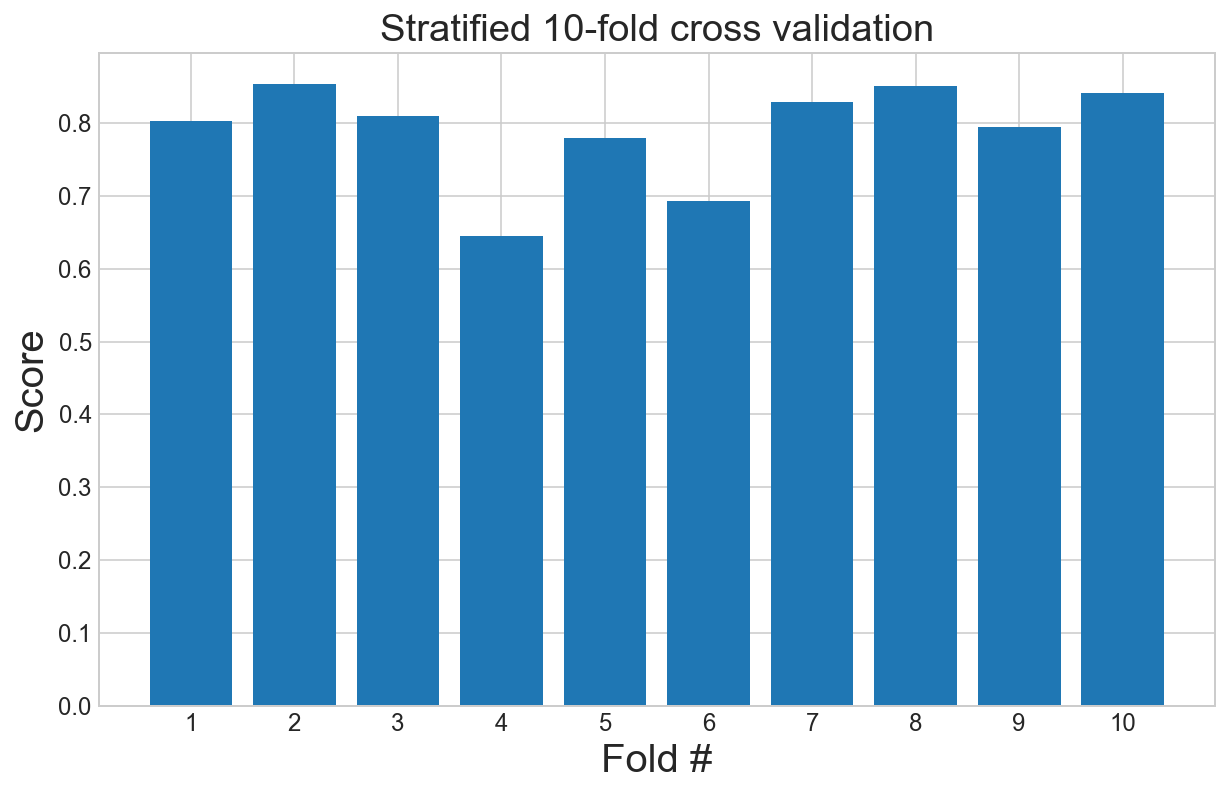

In [95]:
ax = plt.bar(range(len(scores)),scores)
plt.xticks(range(10),range(1,11))
plt.title('Stratified 10-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print('='*50,'Accuracy (ROC AUC): %0.2f (±%0.2f)' % (np.asarray(scores).mean(), np.asarray(scores).std() * 2),'='*50,'\n',sep='\n')

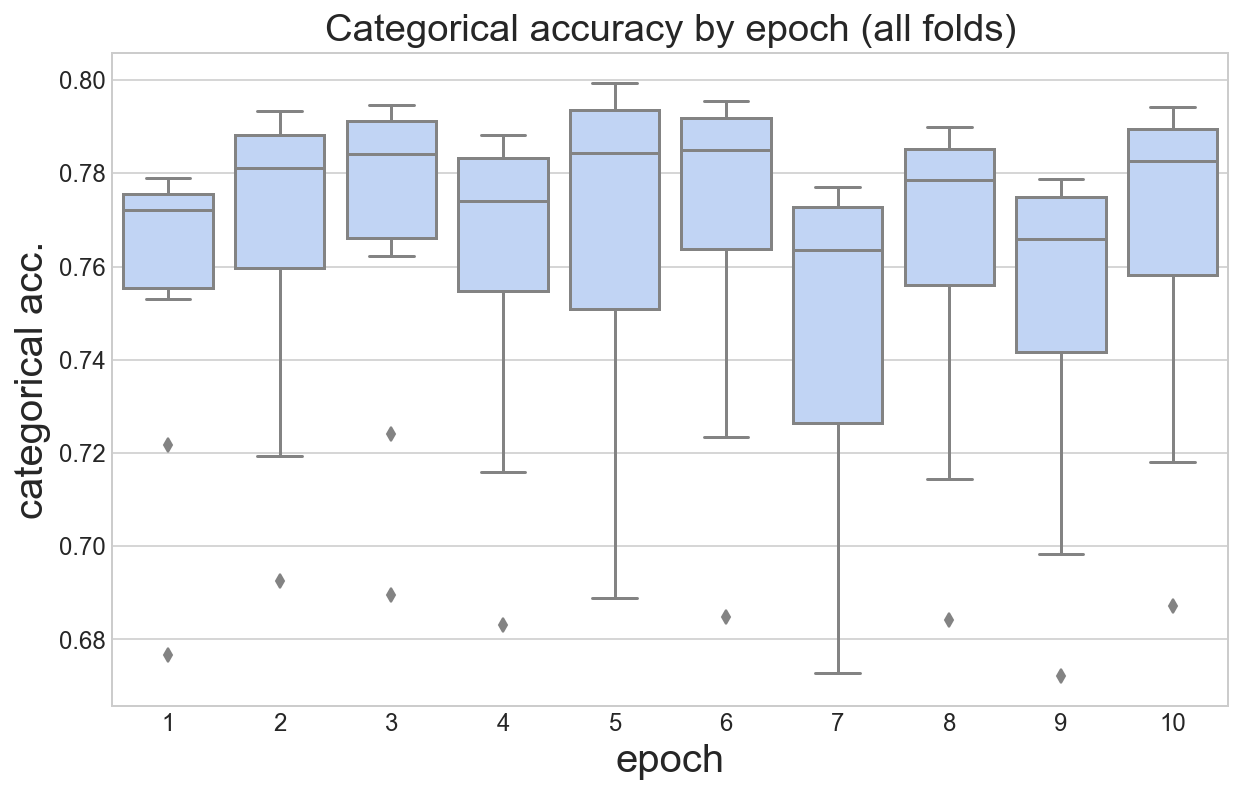

In [91]:
accs = [[epoch['categorical_accuracy'] for epoch in net.epoch_log_] for net in nets]

ax = sns.boxplot(data=np.array(accs).T, color='#b8d2fc')
ax.set_xticklabels(range(1,11))
plt.xlabel('epoch')
plt.ylabel('categorical acc.')
plt.title('Categorical accuracy by epoch (all folds)');

In [ ]:
from sklearn.metrics import confusion_matrix

y_hat_raw = wdNet.predict(y_test)
y_hat = WideDeepNetwork.one_hot_output(y_hat_raw)

cnf = confusion_matrix(y_test, y_hat)
print(cnf)
cnf_norm = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]

sns.heatmap(cnf_norm)
plt.title('Normalized confusion matrix')

In [ ]:
from sklearn.metrics import roc_auc_score


# gets the column of the maximum for each row
# then converts it to binary (manual one-hot encoding)
y_hat_one_hot = np.zeros(y_hat.shape)
y_hat_one_hot[np.arange(y_hat.shape[0]), y_hat.argmax(1)] = 1

# ROC Area under Curve score
roc_auc_score(
    np.asarray(target_test_one_hot),
    y_hat_one_hot
)


In [ ]:
data['clarity'].value_counts().keys().tolist()